In [1]:
import sys
import os

# Get the path to the directory above the current one
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

# 3. Double-check your current directory
print(f"Current Working Directory: {os.getcwd()}")
print(f"Project root added to path. You can now import.")

Current Working Directory: /content
Project root added to path. You can now import.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models

# You'll need to install albumentations!
import albumentations as A
from albumentations.pytorch import ToTensorV2

import time
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from PIL import Image, ImageOps
import copy
import pandas as pd

In [3]:
# ! pip uninstall urllib3
! pip install urllib3

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pascal-voc-2012-dataset' dataset.
Path to dataset files: /kaggle/input/pascal-voc-2012-dataset


In [10]:
import os

# 1. Define source (Read-only) and target (Writable wrapper)
#    Note: We need to point to the actual VOCdevkit folder inside the input
input_root = '/kaggle/input/pascal-voc-2012-dataset'
target_root = '/content/VOCdevkit/VOC2012'

# 2. Create the destination directory structure (but not the final folder)
os.makedirs('/content/VOCdevkit', exist_ok=True)

# 3. Create the Symlink
#    This creates a "ghost" folder at target_root that points to input_root
if not os.path.exists(target_root):
    print(f"Creating symlink: {target_root} -> {input_root}")
    os.symlink(input_root, target_root)
    print("Success! (No copying required)")
else:
    print("Symlink already exists.")

# 4. Verify it works
print("\nVerifying structure...")
!ls -F /content/VOCdevkit/

Symlink already exists.

Verifying structure...
VOC2012@


In [11]:
import shutil
import os

# The path you got from the download
cached_path = '/root/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1'
target_path = '/content/VOCdevkit'

# Check if we already moved it to avoid errors
if not os.path.exists(target_path):
    print(f"Moving data from {cached_path} to {target_path}...")
    # We use move because it's instant (metadata change only)
    shutil.move(cached_path, target_path)
    print("Move complete!")
else:
    print("Data is already in /content/VOCdevkit")

# CRITICAL STEP: Kaggle datasets often have weird nesting.
# Let's find where the actual 'VOC2012' folder is hiding.
print("\nDirectory Structure:")
!find /content/VOCdevkit -maxdepth 2 -type d

Data is already in /content/VOCdevkit

Directory Structure:
/content/VOCdevkit


In [12]:
from core.data_engine import VOCDataEngine

# One call to prepare the entire data pipeline
engine = VOCDataEngine(root_path='/content/VOCdevkit/VOC2012/VOC2012_train_val/VOC2012_train_val')
train_loader, val_loader = engine.get_loaders()


[Optimization] Pre-loading 1464 images and masks into RAM...


100%|██████████| 1464/1464 [03:06<00:00,  7.85it/s]


[Optimization] Loading complete. Training loop is now unblocked.


[Optimization] Pre-loading 1449 images and masks into RAM...


100%|██████████| 1449/1449 [03:04<00:00,  7.87it/s]

[Optimization] Loading complete. Training loop is now unblocked.



In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
class BaseSegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_iou': [], 'val_iou': []
        }
        self.best_iou = 0.0

    def update_history(self, train_loss, val_loss, train_iou, val_iou):
        self.history['train_loss'].append(train_loss.item())
        self.history['val_loss'].append(val_loss.item())
        self.history['train_iou'].append(train_iou.item())
        self.history['val_iou'].append(val_iou.item())

    def save_checkpoint(self, path, epoch, iou):
        if iou > self.best_iou:
            self.best_iou = iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.state_dict(),
                'history': self.history,
                'best_iou': self.best_iou
            }, path)
            print(f"--- Best Model Saved (mIoU: {iou:.4f}) ---")

In [15]:
# BASE U-NET MODEL(SAME AS UNETV1)
class UnetDown(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    model = [
        nn.BatchNorm2d(input_size),
        nn.ELU(),
        nn.Conv2d(input_size, output_size, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(output_size),
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(output_size, output_size, kernel_size=3, stride=1, padding=1)
    ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)

class UnetUp(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()

    model = [
        nn.BatchNorm2d(input_size),
        nn.ELU(),
        nn.Conv2d(input_size, output_size, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(output_size),
        nn.ELU(),
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(output_size, output_size, kernel_size=3, stride=1, padding=1)
    ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)

class UnetV2(BaseSegmentationModel):
  def __init__(self, channels_in, channels_out=2):
    super().__init__()

    self.conv_in = nn.Conv2d(channels_in, 64,
                              kernel_size=3, stride=1, padding=1) # H X W --> H X W

    self.down1 = UnetDown(64, 64) # H X W --> H/2 X W/2
    self.down2 = UnetDown(64, 128) # H/2 X W/2 --> H/4 X W/4
    self.down3 = UnetDown(128, 128) # H/4 X W/4 --> H/8 X W/8
    self.down4 = UnetDown(128, 256) # H/8 X W/8 --> H/16 X W/16

    self.up1 = UnetUp(256, 128) # H/16 X W/16 --> H/8 X W/8
    self.up2 = UnetUp(128 *2, 128) # H/8 X W/8 --> H/4 X W/4
    self.up3 = UnetUp(128 *2, 64) # H/4 X W/4 --> H/2 X W/2
    self.up4 = UnetUp(64 *2, 64) # H/2 X W/2 --> H X W

    self.conv_out = nn.Conv2d(64 * 2, channels_out,
                              kernel_size=3, stride=1, padding=1) # H X W --> H X W

  def forward(self, x):
    x0 = self.conv_in(x) # 16 x H x W

    x1 = self.down1(x0) # 32 x H/2 x W/2
    x2 = self.down2(x1) # 64 x H/4 x W/4
    x3 = self.down3(x2) # 64 x H/8 x W/8
    x4 = self.down4(x3) # 128 x H/16 x W/16

    # Bottle-neck --> 128 x H/16 x W/16

    x5 = self.up1(x4) # 64 x H/8 x W/8

    x5_ = torch.cat((x5, x3), 1) # 128 x H/8 x W/8
    x6 = self.up2(x5_) # 32 x H/4 x W/4

    x6_ = torch.cat((x6, x2), 1) # 64 x H/4 x H/4
    x7 = self.up3(x6_) # 16 x H/2 x W/2

    x7_ = torch.cat((x7, x1), 1) # 64 x H/2 x W/2
    x8 = self.up4(x7_) # 16 x H x W

    x8_ = F.elu(torch.cat((x8, x0), 1)) # 32 x H x W
    return self.conv_out(x8_) # 2 x H x W

In [16]:
unetv2 = UnetV2(channels_in=3, channels_out=21)
device = "cuda" if torch.cuda.is_available() else "cpu"
unetv2 = unetv2.to(device)

In [23]:
from core.losses import MulticlassDiceLoss, FocalLoss2d, LossMixer
from core.accuracy import MulticlassIOU

# Define loss functions
loss_dice = MulticlassDiceLoss()
loss_focal = FocalLoss2d()
loss_fn = LossMixer(loss_dice, loss_focal)

# Define optimizer
optimizer = torch.optim.Adam([
    dict(params=unetv2.parameters(), lr=0.001),
])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

def iou_fn(y_true, y_pred):
    multiclassIOU = MulticlassIOU(num_classes=21)
    iou_score = multiclassIOU.forward(y_pred, y_true)
    return iou_score

In [18]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from diagnostics.model_inspector import ModelInspector

# Attach Inspectors
inspector = ModelInspector(unetv2)
inspector.register_hooks()

print("--- STARTING DIAGNOSTIC RUN (1 Epoch, First Batch Only) ---")

# Run just ONE epoch (or break after 1 batch)
unetv2.train()

epochs = 5

for epoch in range(epochs):
  for batch, (X, y) in enumerate(train_loader):
      if epoch == 4 and batch == 0:
          X, y = X.to(device), y.to(device)

          # 1. Forward Pass (Triggers Forward Hooks)
          print(f"\nProcessing Batch {batch}...")
          y_pred = unetv2(X)

          # 2. Calculate Loss
          loss_ce = loss_fn(y_pred, y)
          total_loss = loss_ce

          # 3. Backward Pass (Triggers Backward Hooks)
          optimizer.zero_grad()
          total_loss.backward()

          # 4. REPORT AND STOP
          # We print the report immediately after the first backward pass
          inspector.print_report()

          # CRITICAL: Stop after n batch so you don't flood your console
          print(f"Diagnosis complete for Batch {batch}. Stopping.")

# Clean up hooks so they don't interfere with future runs
inspector.clear_hooks()

DEBUG: Attached inspectors to 34 layers.
--- STARTING DIAGNOSTIC RUN (1 Epoch, First Batch Only) ---

Processing Batch 0...


sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.



LAYER (Forward)                | Mean       | Std        | Status
------------------------------------------------------------
conv_in                        | 0.0119     | 0.6517     | OK
down1.model.0                  | 0.0000     | 1.0000     | OK
down1.model.2                  | -0.0040     | 0.4351     | OK
down1.model.3                  | 0.0000     | 1.0000     | OK
down1.model.6                  | -0.0049     | 0.5245     | OK
down2.model.0                  | 0.0000     | 1.0000     | OK
down2.model.2                  | -0.0117     | 0.4651     | OK
down2.model.3                  | 0.0000     | 1.0000     | OK
down2.model.6                  | 0.0245     | 0.5929     | OK
down3.model.0                  | -0.0000     | 1.0000     | OK
down3.model.2                  | 0.0094     | 0.4646     | OK
down3.model.3                  | 0.0000     | 1.0000     | OK
down3.model.6                  | 0.0203     | 0.6085     | OK
down4.model.0                  | 0.0000     | 1.0000     | OK


In [19]:
from timeit import default_timer as timer

def print_train_time(start:float,
                     end: float,
                     device: torch.device=None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [20]:
unetv2 = UnetV2(channels_in=3, channels_out=21)
device = "cuda" if torch.cuda.is_available() else "cpu"
unetv2 = unetv2.to(device)

In [ ]:
# Define loss functions
loss_dice = MulticlassDiceLoss()
loss_focal = FocalLoss2d()
loss_fn = LossMixer(loss_dice, loss_focal)

# Define optimizer
optimizer = torch.optim.Adam([
    dict(params=unetv2.parameters(), lr=0.001),
])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

def iou_fn(y_true, y_pred):
    multiclassIOU = MulticlassIOU(num_classes=21)
    iou_score = multiclassIOU.forward(y_pred, y_true)
    return iou_score

In [21]:
import sys
import importlib
import core.accuracy

# 1. Force a reload of the specific module
importlib.reload(core.accuracy)

# 2. Re-import the classes to the global namespace
from core.training import Training, EarlyStopping

print("Memory Purged. StaticMethods should be active now.")

Memory Purged. StaticMethods should be active now.


If you come across `
AssertionError: No inf checks were recorded for this optimizer.` error when running the training code, just restart optimizer after the model initiation. This error occurs because PyTorch requires model and optimizer be on the same device in order to do AMP.

In [24]:
torch.manual_seed(42)

from core.training import Training, EarlyStopping

training = Training()

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Initialize early stopping
early_stopper = EarlyStopping(patience=7, min_delta=0.01)

# Set epochs
epochs = 50

# Create an optimizeation and evaluation loop using train_step() and valid_step()
for epoch in tqdm(range(epochs)):
  input_x, label_x = next(iter(train_loader))
  input_y, label_y = next(iter(val_loader))
  t_loss, t_iou = T=training.train_step(model=unetv2,
             data_loader=train_loader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=iou_fn,
             device=device)
  v_loss, v_iou = training.valid_step(model=unetv2,
            data_loader=val_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=iou_fn,
            device=device)

  unetv2.update_history(t_loss, v_loss, t_iou, v_iou)

  # 3. Check Early Stopping
  early_stopper(v_loss)
  if early_stopper.early_stop:
      unetv2.save_checkpoint("best_unet_v2.pth", epoch, v_iou)
      print(f"Early stopping at epoch {epoch}. Model is no longer improving.")
      break

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Looked at 0/1464 samples
Train loss: 1.01765 | Train acc: 73.28%

Valid loss: 0.96206 | Valid acc: 73.88%

Looked at 0/1464 samples
Train loss: 0.94834 | Train acc: 74.98%

Valid loss: 0.94389 | Valid acc: 74.68%

Looked at 0/1464 samples
Train loss: 0.93373 | Train acc: 74.93%

Valid loss: 0.93560 | Valid acc: 74.64%

EarlyStopping counter: 1 out of 7
Looked at 0/1464 samples
Train loss: 0.92636 | Train acc: 74.73%

Valid loss: 0.92219 | Valid acc: 74.71%

Looked at 0/1464 samples
Train loss: 0.90886 | Train acc: 75.14%

Valid loss: 0.92737 | Valid acc: 74.67%

EarlyStopping counter: 1 out of 7
Looked at 0/1464 samples
Train loss: 0.89700 | Train acc: 75.06%

Valid loss: 0.92636 | Valid acc: 73.06%

EarlyStopping counter: 2 out of 7
Looked at 0/1464 samples
Train loss: 0.89105 | Train acc: 75.09%

Valid loss: 0.90926 | Valid acc: 75.29%

Looked at 0/1464 samples
Train loss: 0.88943 | Train acc: 74.84%

Valid loss: 0.90621 | Valid acc: 74.78%

EarlyStopping counter: 1 out of 7
Looked a

In [25]:
def plot_evolution(data, target, predictions, titles, num_classes=21):
    """
    data: Original image [C, H, W]
    target: Ground truth mask [H, W]
    predictions: List of model outputs or masks
    titles: List of titles for each prediction (e.g., ["Baseline", "Weighted CE"])
    """
    num_plots = 2 + len(predictions)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    cmap = plt.get_cmap('tab20', num_classes)

    # 1. Original Image
    img = data[0].permute(1, 2, 0).cpu().numpy().squeeze()
    # Add denormalization logic here if you used transforms.Normalize
    axes[0].imshow(img)
    axes[0].set_title("Original Image")

    # 2. Ground Truth
    axes[1].imshow(target[0].cpu(), cmap=cmap, vmin=0, vmax=num_classes-1)
    axes[1].set_title("Ground Truth")

    # 3. Model Predictions
    for i, pred in enumerate(predictions):
        mask = pred[0].cpu().numpy()
        axes[i+2].imshow(mask, cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[i+2].set_title(titles[i])

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [26]:
checkpoint = torch.load('best_unet_v2.pth', weights_only=True)
unetv2.load_state_dict(checkpoint['model_state_dict'])
unetv2.eval()

UnetV2(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): UnetDown(
    (model): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ELU(alpha=1.0)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ELU(alpha=1.0)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (down2): UnetDown(
    (model): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ELU(alpha=1.0)
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ELU(alpha=1.0)
      (5): MaxPool2d(kern

In [27]:
valid_iter = iter(val_loader)

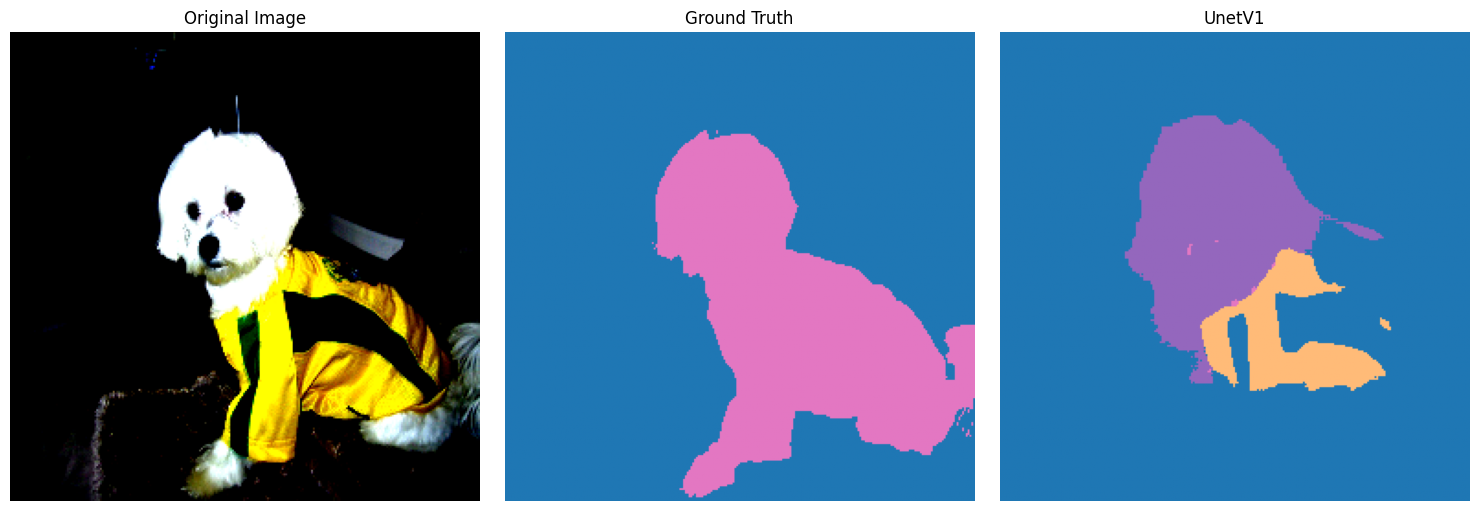

In [80]:
# Get one batch from validation
data, target = next(valid_iter)
unetv2.eval()
output = unetv2(data.to(device))
pred = output.argmax(dim=1) # Convert probabilities to class labels


plot_evolution(data, target, [pred], ["UnetV2"])

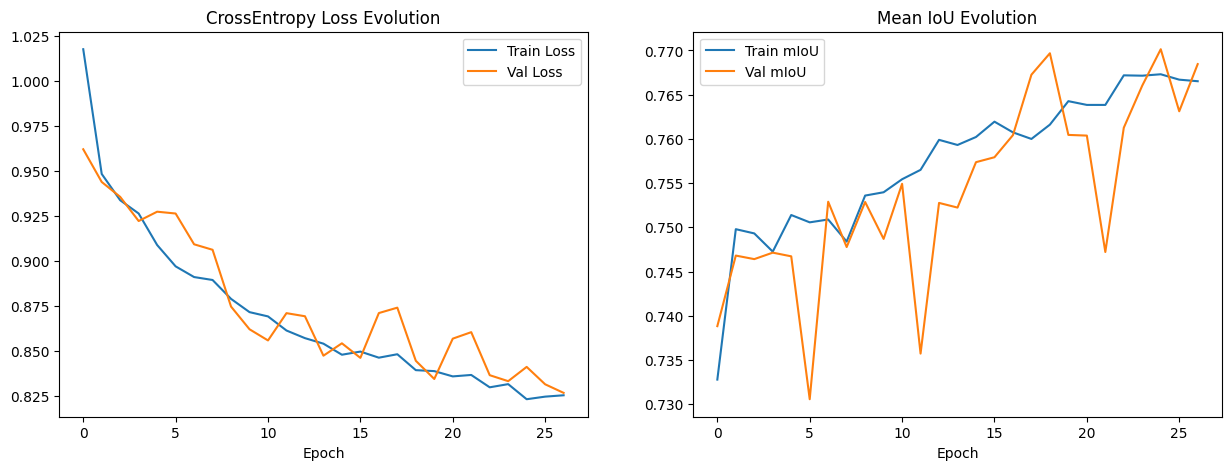

In [81]:
def plot_metrics(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss Plot
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_title('CrossEntropy Loss Evolution')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()

    # IoU Plot
    axes[1].plot(history['train_iou'], label='Train mIoU')
    axes[1].plot(history['val_iou'], label='Val mIoU')
    axes[1].set_title('Mean IoU Evolution')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()

    plt.show()

plot_metrics(unetv2.history)